In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

import os
import sys
import logging

In [3]:
adata_infile = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/objects/stream_input_filtered_cells_v7.h5ad"
barcodes_dir = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/SLIDE_cell_barcodes'
#stream_object = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/actb1_added/stream_traj_v5.pkl'
stream_object = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/objects/mlle_traj_male_donor.pkl'
out_dir = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/objects'

In [4]:
!rsync -aP $stream_object /dev/shm/

sending incremental file list


In [4]:
from os.path import basename
import stream as st
#read the stream result file pkl or h5ad
adata = st.read(file_name='/dev/shm/' + os.path.basename(stream_object), workdir=out_dir)


/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


Working directory is already specified as '/tmp/tmpxe4adudq' 
To change working directory, please run set_workdir(adata,workdir=new_directory)


In [5]:
adata

AnnData object with n_obs × n_vars = 28494 × 4142
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'score_G1S', 'score_G2M', 'score_myc_up', 'score_GC', 'score_PB', 'score_MBC_1', 'score_MBC_2', 'score_preGC', 'score_LZ_GC', 'score_DZ_GC', 'DNA_damage', 'LZ_vs_DZ_down', 'LZ_vs_DZ_up', 'Ag_presentation', 'BCR_signaling', 'leiden_filtered_cells', 'cell_type_annotation', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts

#### Add obs of interest

In [6]:
window_1_barcodes = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic/Subset1/names_rna.txt'
window_2_barcodes = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic/Subset2/names_rna.txt'
window_3_barcodes = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic/Subset3/names_rna.txt'
window_4_barcodes = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic/Subset4/names_rna.txt'
window_194_barcodes = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic/Subset194/names_rna.txt'
windows_147_barcodes = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/tmp_dynamic/Subset147/names_rna.txt'

In [7]:
# latent factor values
z_matrix = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/z_matrix.csv'

In [8]:
import pandas as pd
# Read barcodes from each window file and create DataFrames
window_files = {
    'window1': window_1_barcodes,
    'window2': window_2_barcodes,
    'window3': window_3_barcodes,
    'window4': window_4_barcodes,
    'window194': window_194_barcodes,
    'window147': windows_147_barcodes
}

# Create DataFrames for each window
for window_name, file_path in window_files.items():
    # Read barcodes from file
    df = pd.read_csv(file_path, header=None, names=['Barcode'])
    # Create a new column with window name, set to the window name for all rows
    df[window_name] = window_name
    # Set barcode as index
    df = df.set_index('Barcode')
    
    # Add to adata.obs, merging on index (cell barcodes)
    # This will automatically set NaN for cells not in the window
    adata.obs = adata.obs.join(df[window_name])
    
    # Convert to categorical with NA for missing values
    adata.obs[window_name] = adata.obs[window_name].astype('category')

In [9]:
import pandas as pd
z_matrix_df = pd.read_csv(z_matrix)
z_matrix_df = z_matrix_df.set_index('Unnamed: 0')
# get the column Z11 and Z3 in a separate df
lf_gc_pb_df = z_matrix_df[['Z11','Z3']]
# add the lf_gc_pb_df to adata.obs
adata.obs = adata.obs.join(lf_gc_pb_df)
# convert the lf_gc_pb_df to categorical
adata.obs[['Z11','Z3']] = adata.obs[['Z11','Z3']].astype('category')

In [6]:
adata.obs.head()

,sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,topic_0,topic_1,topic_2,topic_3,...,D2_per_BATF,D2_per_IRF4,D2_per_SPIB,D2_per_PRDM1,D2_per_IRF8,D4_per_BATF,D4_per_IRF4,D4_per_SPIB,D4_per_PRDM1,D4_per_IRF8
AAACAGCCAAGCCACT-3,day5_6,3580,3580,3657.756836,54.042961,1.372567,0.018575,0.013160,0.008065,0.036125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAAGGTGCA-1,day0_2,2415,2415,3112.943604,52.210323,1.541318,0.038631,0.025551,0.318661,0.011544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAAGTTATC-1,day0_2,1435,1435,2431.045410,51.333004,1.906349,0.015908,0.023365,0.006621,0.007612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAATAGCCC-1,day0_2,1349,1349,2333.001465,47.939995,1.839260,0.011711,0.010980,0.044246,0.010271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAGTTAGCC-1,day0_2,2017,2017,2874.929443,49.748478,1.569514,0.016863,0.013082,0.135453,0.012727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# get the cell counts per cell type
cell_counts = adata.obs['cell_type_annotation'].value_counts()
cell_counts

ActB_1        5283
ActB_2        4647
ActB_4        4440
GC_1          4365
ActB_3        3984
GC_2          2515
PB_1          2345
early_PB       657
early_ActB     258
Name: cell_type_annotation, dtype: int64

In [8]:
# add an obs column which is the same for all cells and says gray
adata.obs['gray'] = 'gray'

# Run stream dim reduction (LLE) on the anndata, with imputed gene expression and filtered cells

In [9]:
#set the imputed gene expression as the accessible data layer
adata.X = adata.layers['MAGIC_imputed_data']

In [16]:
# # Setting var_genes if you need to select top 3k genes from a list of more than 3k genes
# st.select_variable_genes(adata,loess_frac=0.01,percentile=80)

In [17]:
# # 'var_genes' vs 'all' : use top % or all genes from .var ; if using all make sure the adata is subsetted to only the highly variable genes
# # n_components = Number of branches present in your biological differentation
# st.dimension_reduction(adata,method='mlle',feature='var_genes',n_components=2,n_neighbors=30,n_jobs=64) # using the same knn as diffusion maps (default is 30)

#### Order cell types based on how you think the pseudotime should be

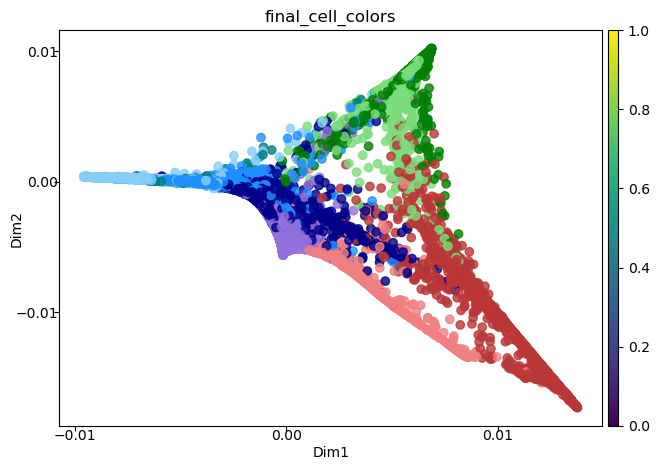

In [10]:
# Order the cell states for plotting (colors need to be categorical)
adata.obs['cell_type_annotation'] = pd.Categorical(
    adata.obs['cell_type_annotation'],
    categories=['early_ActB', 'ActB_1', 'ActB_2', 'ActB_3', 'ActB_4', 'GC_1', 'GC_2', 'early_PB', 'PB_1'],
    ordered=True
)

leiden_color_dict = {
    'ActB_1': '#87CEFA',     # lightskyblue
    'ActB_2': '#1E90FF',     # dodgerblue
    'ActB_4': '#9370DB',     # mediumorchid
    'GC_1': '#7BDE7B',       # custom light green
    'ActB_3': '#00008B',     # darkblue
    'GC_2': '#008000',       # green
    'PB_1': '#BB3636',       # custom red
    'early_PB': '#F08080',    # lightcoral
    'early_ActB': '#008080'   # teal
}

# Create a new column in adata.obs for colors
adata.obs['final_cell_colors'] = adata.obs['cell_type_annotation'].map(leiden_color_dict)
# Now plot using this new column
st.plot_dimension_reduction(adata, color=['final_cell_colors'], n_components=2)

# Visualize the UMAP with selected cells

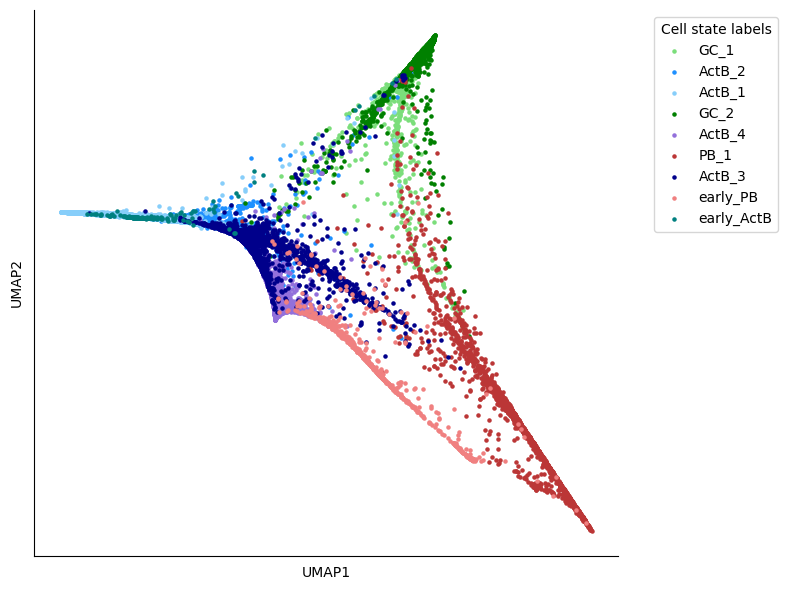

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr'/'X_mlle' slot 
umap_coords = adata.obsm['X_mlle']

# Extract the labels for coloring
labels = adata.obs['cell_type_annotation']

# Get unique labels and their corresponding colors
unique_labels = labels.unique()
color_list = [leiden_color_dict[label] for label in unique_labels]

# Plotting the UMAP with colors based on labels
plt.figure(figsize=(8, 6))

for label, color in zip(unique_labels, color_list):
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=color, label=label, s=5)  # s=5 sets the marker size to 5 points
# Remove ticks
plt.xticks([])
plt.yticks([])
# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title="Cell state labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/figures/bifurcation_male.pdf', 
#             bbox_inches='tight',  # Ensures the legend isn't cut off
#             dpi=300,             # High resolution
#             format='pdf')        # Specify PDF format
plt.show()

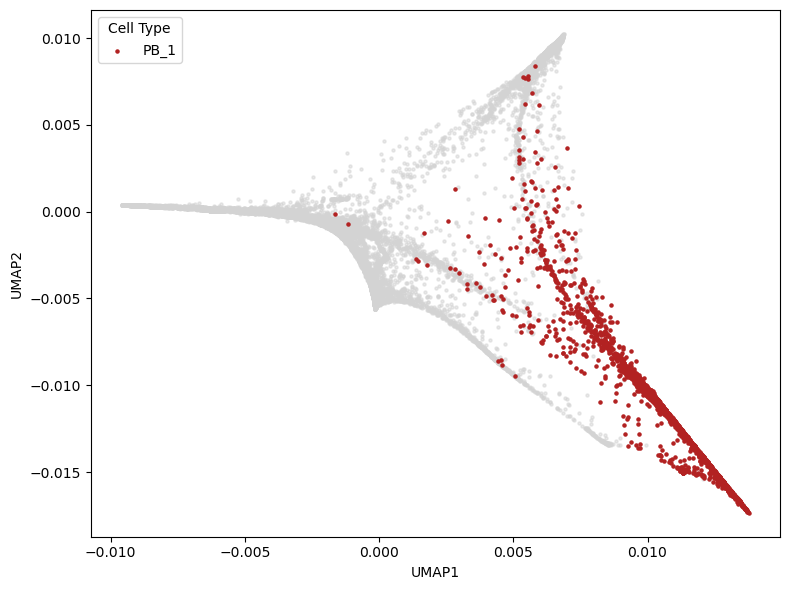

In [24]:
# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_mlle']

# Extract the labels for coloring
labels = adata.obs['cell_type_annotation']

# Define colors
highlight_color = 'firebrick'  # Original PB-2 color
background_color = '#D3D3D3'  # Light gray

# Create the plot
plt.figure(figsize=(8, 6))

# Plot background (all non-PB-2 cells) first
background_mask = labels != 'PB_1'
plt.scatter(umap_coords[background_mask, 0], umap_coords[background_mask, 1], 
           c=background_color, s=5, alpha=0.5)

# Plot PB-2 cells
actb4_mask = labels == 'PB_1'
plt.scatter(umap_coords[actb4_mask, 0], umap_coords[actb4_mask, 1], 
           c=highlight_color, s=5, label='PB_1')

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title="Cell Type", loc='upper left')
plt.tight_layout()
plt.show()

### Viz LF score on the traj

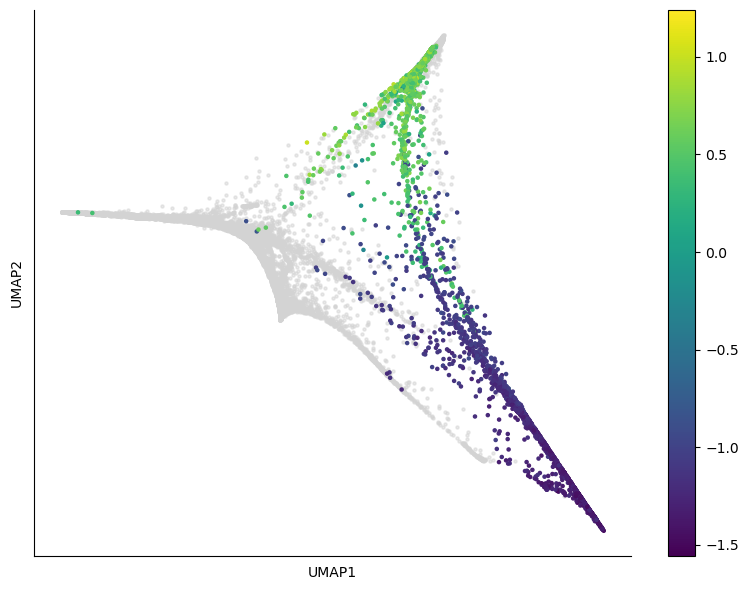

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_mlle']

# Replace 'score_column' with your actual score column name
z11_score = adata.obs['Z11']  

# Create the plot
plt.figure(figsize=(8, 6))

# Plot background (cells with NaN scores) first
background_mask = z11_score.isna()
plt.scatter(umap_coords[background_mask, 0], umap_coords[background_mask, 1], 
           c='#D3D3D3', s=5, alpha=0.5)

# Plot cells with scores using a colormap
score_mask = ~z11_score.isna()
scatter = plt.scatter(umap_coords[score_mask, 0], umap_coords[score_mask, 1], 
                     c=z11_score[score_mask], s=5, 
                     cmap='viridis')
# Remove ticks
plt.xticks([])
plt.yticks([])
# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('')
# Add colorbar
plt.colorbar(scatter, label='')
plt.title('')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/figures/Z11_male_traj.pdf', 
#             bbox_inches='tight',  # Ensures the legend isn't cut off
#             dpi=300,             # High resolution
#             format='pdf')
plt.show()

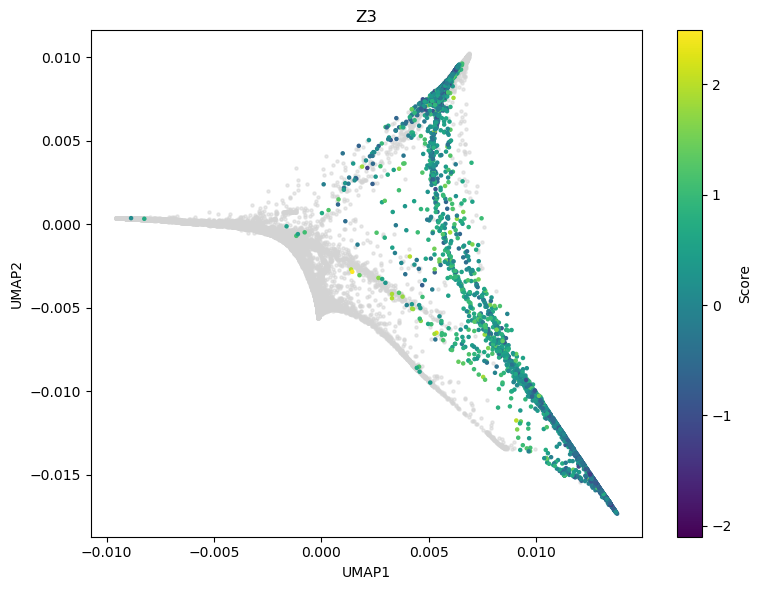

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_mlle']

# Replace 'score_column' with your actual score column name
z3_score = adata.obs['Z3']  

# Create the plot
plt.figure(figsize=(8, 6))

# Plot background (cells with NaN scores) first
background_mask = z3_score.isna()
plt.scatter(umap_coords[background_mask, 0], umap_coords[background_mask, 1], 
           c='#D3D3D3', s=5, alpha=0.5)

# Plot cells with scores using a colormap
score_mask = ~z3_score.isna()
scatter = plt.scatter(umap_coords[score_mask, 0], umap_coords[score_mask, 1], 
                     c=z3_score[score_mask], s=5, 
                     cmap='viridis')

# Add colorbar
plt.colorbar(scatter, label='Score')
plt.title('Z3')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.tight_layout()
plt.show()

#### Viz window specific cells

In [38]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Extract UMAP coordinates from the 'X_dr' slot 
# umap_coords = adata.obsm['X_dr']

# # Define colors
# highlight_color = '#1f77b4'  # Blue for highlighted cells
# background_color = '#D3D3D3'  # Light gray for background

# # Get all window columns
# window_columns = ['window1', 'window2', 'window3', 'window4', 'window194', 'window147']

# # Create a plot for each window
# for window in window_columns:
#     plt.figure(figsize=(8, 6))
    
#     # Plot background (all cells) first
#     plt.scatter(umap_coords[:, 0], umap_coords[:, 1], 
#                c=background_color, s=5, alpha=0.5)
    
#     # Plot cells assigned to this window
#     window_mask = ~adata.obs[window].isna()  # True for cells in this window
#     if window_mask.any():  # Only plot if there are cells in this window
#         plt.scatter(umap_coords[window_mask, 0], umap_coords[window_mask, 1], 
#                    c=highlight_color, s=5, label=window)
    
#     plt.title(f'UMAP: {window} cells')
#     plt.xlabel('UMAP1')
#     plt.ylabel('UMAP2')
#     plt.legend(title="Window Assignment", loc='upper left')
#     plt.tight_layout()
#     plt.show()

# # Print statistics
# print("\nNumber of cells in each window:")
# for window in window_columns:
#     n_cells = (~adata.obs[window].isna()).sum()
#     print(f"{window}: {n_cells} cells")

In [39]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Extract UMAP coordinates from the 'X_dr' slot 
# umap_coords = adata.obsm['X_dr']

# # Extract the labels for coloring
# labels = adata.obs['cell_type_major']

# # Get unique labels
# unique_labels = labels.unique()

# # Define a color for the highlighted cells and for the background cells
# highlight_color = '#1f77b4'  # A shade of blue
# background_color = '#D3D3D3'  # Light gray

# # Create a plot for each unique label
# for label in unique_labels:
#     plt.figure(figsize=(8, 6))
    
#     # Plot background (gray) points first
#     plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=background_color, s=5, alpha=0.5)
    
#     # Plot highlighted points
#     idx = labels == label
#     plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=highlight_color, s=5, label=label)

#     plt.title(f'UMAP: {label} cells highlighted')
#     plt.xlabel('UMAP1')
#     plt.ylabel('UMAP2')
#     plt.legend(title="Highlighted Cells", loc='upper left')
#     plt.tight_layout()
#     plt.show()

# Cell fate Predisposition

In [11]:
# load cell barcodes from perturb-seq data and SLIDE analysis
day2_cells = ['D2_per_BATF.csv', 'D2_per_IRF4.csv', 'D2_per_SPIB.csv', 'D2_per_PRDM1.csv', 'D2_per_IRF8.csv']
day4_cells = ['D4_per_BATF.csv', 'D4_per_IRF4.csv', 'D4_per_SPIB.csv', 'D4_per_PRDM1.csv', 'D4_per_IRF8.csv']   

# Function to read CSV and add perturbation column
def read_csv_with_perturbation(filename):
    df = pd.read_csv(os.path.join(barcodes_dir, filename))
    perturbation = filename.split('.')[0]  # Remove .csv
    df['Perturbation'] = perturbation
    return df

# Read and combine day2 cells
day2_cells_df = pd.concat([read_csv_with_perturbation(file) for file in day2_cells], ignore_index=True)
day4_cells_df = pd.concat([read_csv_with_perturbation(file) for file in day4_cells], ignore_index=True)

# Rename the first column to 'Barcode'
day2_cells_df = day2_cells_df.rename(columns={day2_cells_df.columns[0]: 'Barcode'})
day4_cells_df = day4_cells_df.rename(columns={day4_cells_df.columns[0]: 'Barcode'})

display(day2_cells_df)
display(day4_cells_df)

,Barcode,x,Perturbation
0,AAACATGCACAGAAAC-1,-0.529038,D2_per_BATF
1,AAACCGAAGGACACTT-1,-0.197921,D2_per_BATF
2,AAACCGAAGTCATGCG-1,-0.293773,D2_per_BATF
3,AAACCGGCACAGAACG-1,-0.470738,D2_per_BATF
4,AAACCGGCAGGCGAGT-1,-0.436003,D2_per_BATF
...,...,...,...
3784,TTTGAGTCAAAGCGCA-1,0.351522,D2_per_IRF8
3785,TTTGCGGAGCAGGTGG-1,1.097622,D2_per_IRF8
3786,TTTGTCCCAAGGATTA-1,0.144348,D2_per_IRF8
3787,TTTGTTGGTAATAACC-1,0.324435,D2_per_IRF8


,Barcode,x,Perturbation
0,AAACGGATCGATATTG-2,-0.037349,D4_per_BATF
1,AAAGCAAGTGGTGAGA-2,-0.296665,D4_per_BATF
2,AACCGCTCAGATTCAT-2,-0.167110,D4_per_BATF
3,AACGCCCAGTTTGGTA-2,-0.083701,D4_per_BATF
4,AACGCTAGTAACCTAG-2,-0.388721,D4_per_BATF
...,...,...,...
3424,TTTGACCGTAGCTGGT-2,0.010884,D4_per_IRF8
3425,TTTGAGTCAGGCATGA-2,0.413497,D4_per_IRF8
3426,TTTGCGACAGCTCATA-2,0.247754,D4_per_IRF8
3427,TTTGTCTAGGCAGGTG-2,-0.020430,D4_per_IRF8


In [12]:
# add 10 new fields to adata.obs named the Perturbation names and set them as categorical
day2_perturbations = day2_cells_df['Perturbation'].unique()
day4_perturbations = day4_cells_df['Perturbation'].unique()
all_perturbations = np.concatenate([day2_perturbations, day4_perturbations])

# Create a dictionary for each perturbation mapping barcodes to perturbation names
perturbation_maps = {}
for pert in day2_perturbations:
    barcodes = day2_cells_df[day2_cells_df['Perturbation'] == pert]['Barcode']
    perturbation_maps[pert] = dict.fromkeys(barcodes, pert)
    
for pert in day4_perturbations:
    barcodes = day4_cells_df[day4_cells_df['Perturbation'] == pert]['Barcode']
    perturbation_maps[pert] = dict.fromkeys(barcodes, pert)

# Add a column for each perturbation
for pert in all_perturbations:
    adata.obs[pert] = adata.obs.index.map(perturbation_maps[pert])
    # Convert to categorical with NA for missing values
    adata.obs[pert] = adata.obs[pert].astype('category')

# Verify the results
print("\nSample of cells with their perturbation assignments:")
display(adata.obs[all_perturbations].head())

# Print some statistics
print("\nNumber of cells assigned to each perturbation:")
for pert in all_perturbations:
    n_cells = adata.obs[pert].notna().sum()
    print(f"{pert}: {n_cells} cells")


Sample of cells with their perturbation assignments:


,D2_per_BATF,D2_per_IRF4,D2_per_SPIB,D2_per_PRDM1,D2_per_IRF8,D4_per_BATF,D4_per_IRF4,D4_per_SPIB,D4_per_PRDM1,D4_per_IRF8
AAACAGCCAAGCCACT-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAAGGTGCA-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAAGTTATC-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAATAGCCC-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAGTTAGCC-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Number of cells assigned to each perturbation:
D2_per_BATF: 609 cells
D2_per_IRF4: 820 cells
D2_per_SPIB: 465 cells
D2_per_PRDM1: 1242 cells
D2_per_IRF8: 653 cells
D4_per_BATF: 447 cells
D4_per_IRF4: 803 cells
D4_per_SPIB: 271 cells
D4_per_PRDM1: 1267 cells
D4_per_IRF8: 641 cells


### Subset cells to Day 2 ActBs

In [13]:
adata_actb2 = adata[adata.obs['cell_type_annotation'] == 'ActB_2']
adata_actb2 

View of AnnData object with n_obs × n_vars = 4647 × 4142
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'score_G1S', 'score_G2M', 'score_myc_up', 'score_GC', 'score_PB', 'score_MBC_1', 'score_MBC_2', 'score_preGC', 'score_LZ_GC', 'score_DZ_GC', 'DNA_damage', 'LZ_vs_DZ_down', 'LZ_vs_DZ_up', 'Ag_presentation', 'BCR_signaling', 'leiden_filtered_cells', 'cell_type_annotation', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total

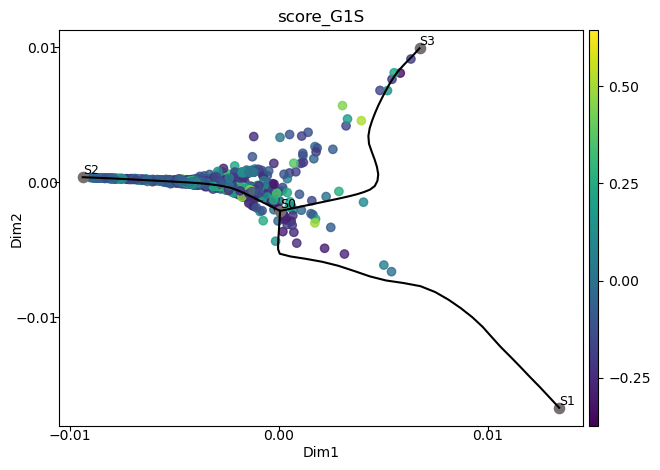

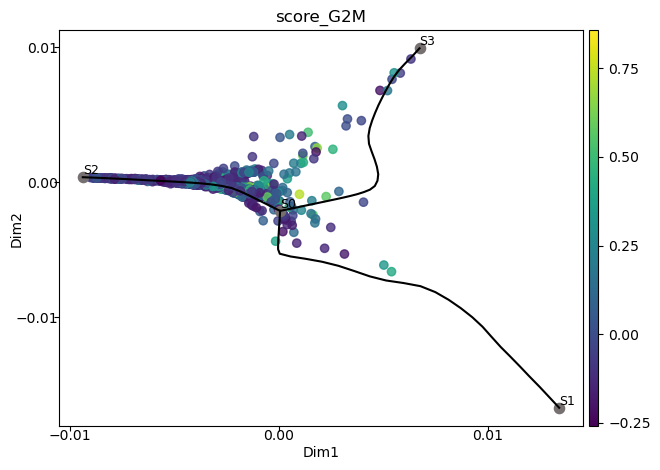

In [22]:
st.plot_dimension_reduction(adata_actb2,show_graph=True,show_text=True,color=['score_G1S'])
st.plot_dimension_reduction(adata_actb2,show_graph=True,show_text=True,color=['score_G2M'])

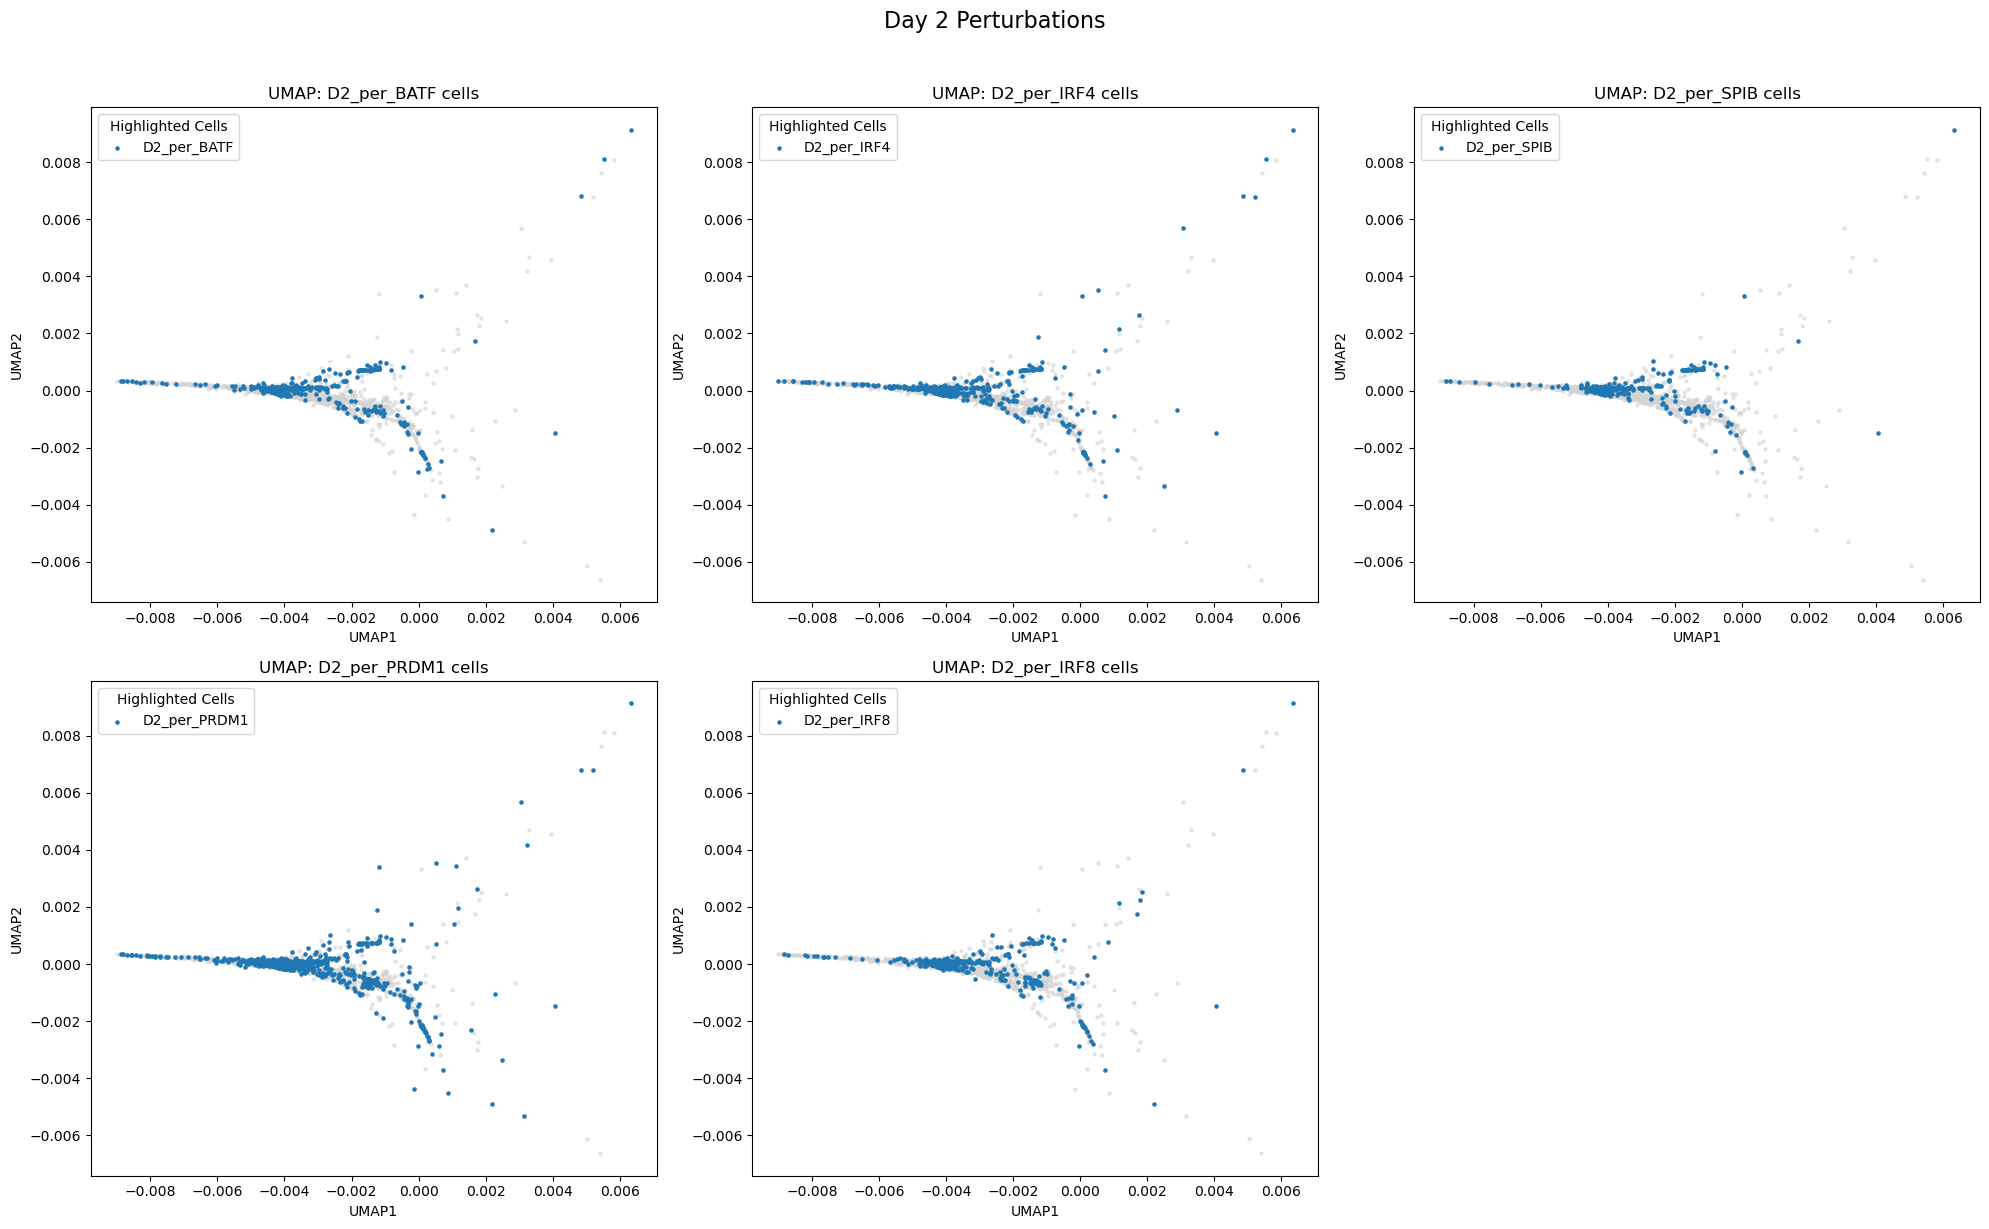

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata_actb2.obsm['X_mlle']

# Separate day2 and day4 perturbations
day2_perturbations = [pert for pert in all_perturbations if pert.startswith('D2_')]

# Define colors
highlight_color = '#1f77b4'  # A shade of blue
background_color = '#D3D3D3'  # Light gray

# Create plots for Day 2 perturbations
plt.figure(figsize=(20, 12))
for i, pert in enumerate(day2_perturbations, 1):
    plt.subplot(2, 3, i)
    
    # Plot background (gray) points first
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], 
               c=background_color, s=5, alpha=0.5)
    
    # Plot highlighted points (cells with non-NA values for this perturbation)
    idx = adata_actb2.obs[pert].notna()
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], 
               c=highlight_color, s=5, label=pert)

    plt.title(f'UMAP: {pert} cells')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title="Highlighted Cells", loc='upper left')

plt.suptitle('Day 2 Perturbations', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

### Subset cells to Day4 ActBs

In [15]:
adata_actb4 = adata[adata.obs['cell_type_annotation'] == 'ActB_4']
adata_actb4 

View of AnnData object with n_obs × n_vars = 4440 × 4142
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'score_G1S', 'score_G2M', 'score_myc_up', 'score_GC', 'score_PB', 'score_MBC_1', 'score_MBC_2', 'score_preGC', 'score_LZ_GC', 'score_DZ_GC', 'DNA_damage', 'LZ_vs_DZ_down', 'LZ_vs_DZ_up', 'Ag_presentation', 'BCR_signaling', 'leiden_filtered_cells', 'cell_type_annotation', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total

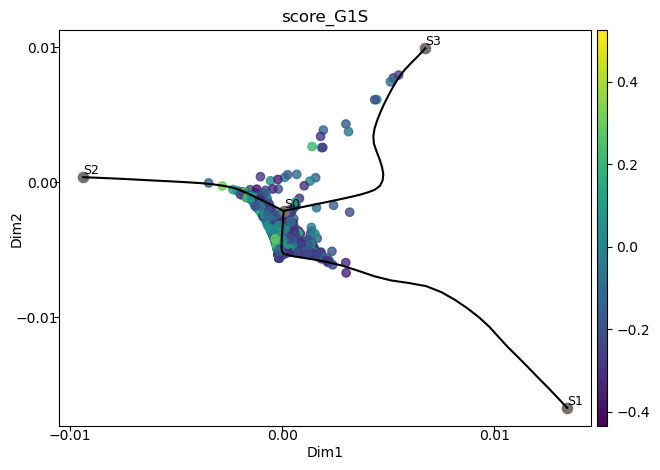

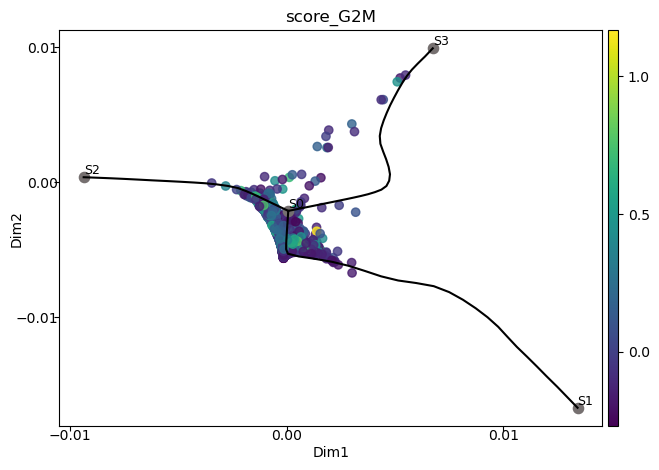

In [21]:
st.plot_dimension_reduction(adata_actb4,show_graph=True,show_text=True,color=['score_G1S'])
st.plot_dimension_reduction(adata_actb4,show_graph=True,show_text=True,color=['score_G2M'])

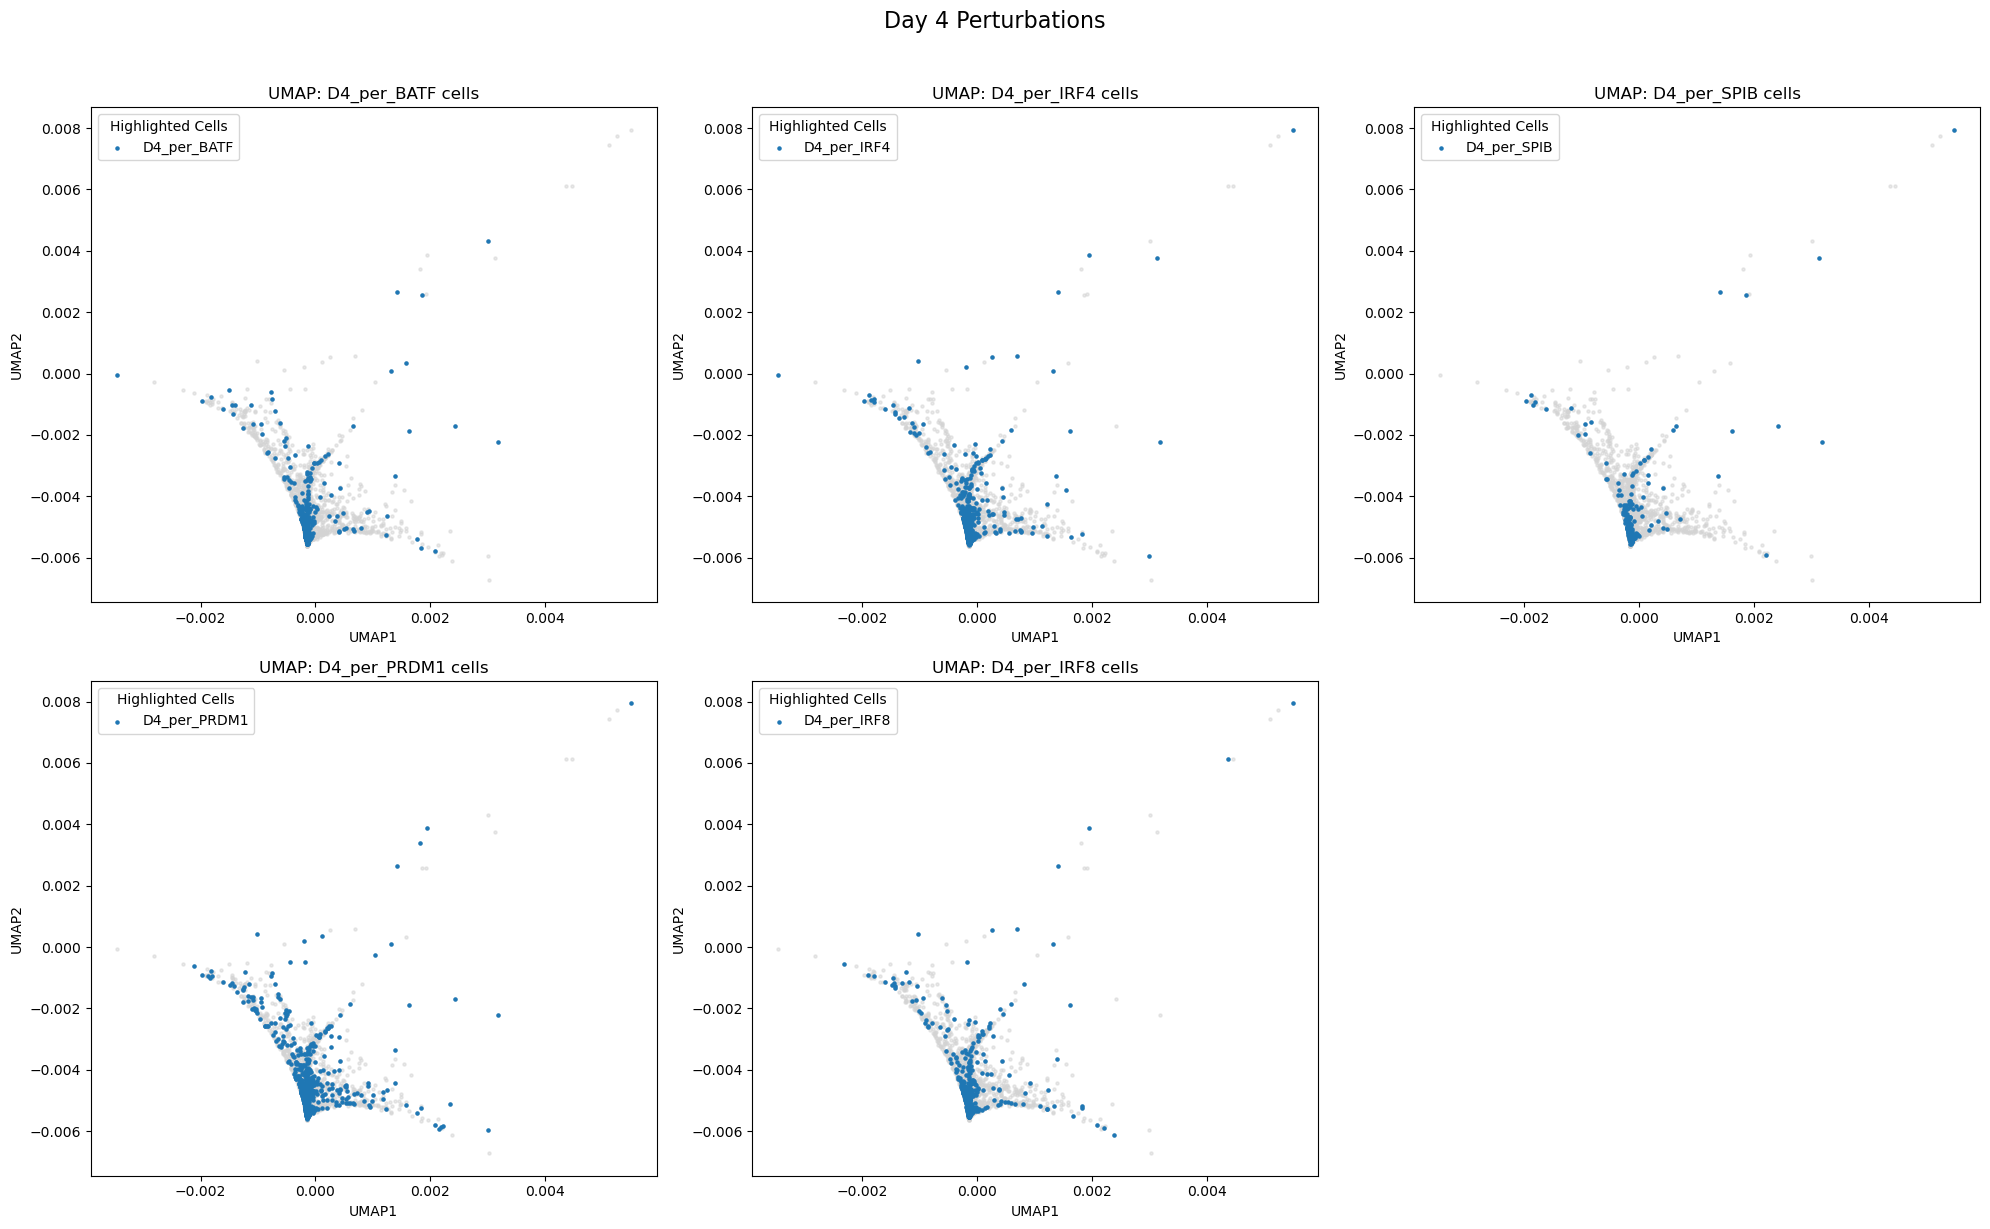

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata_actb4.obsm['X_mlle']
day4_perturbations = [pert for pert in all_perturbations if pert.startswith('D4_')]

# Define colors
highlight_color = '#1f77b4'  # A shade of blue
background_color = '#D3D3D3'  # Light gray
# Create plots for Day 4 perturbations
plt.figure(figsize=(20, 12))
for i, pert in enumerate(day4_perturbations, 1):
    plt.subplot(2, 3, i)
    
    # Plot background (gray) points first
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], 
               c=background_color, s=5, alpha=0.5)
    
    # Plot highlighted points (cells with non-NA values for this perturbation)
    idx = adata_actb4.obs[pert].notna()
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], 
               c=highlight_color, s=5, label=pert)

    plt.title(f'UMAP: {pert} cells')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title="Highlighted Cells", loc='upper left')

plt.suptitle('Day 4 Perturbations', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

# Trajectory inference by fitting elastic graph

In [30]:
# import os
# os.environ["OMP_NUM_THREADS"] = "64"
# from tempfile import TemporaryDirectory
# from rpy2.robjects import r
# # Load the rlang package in R
# r('library(rlang)')

# # Parameters for STREAM (tune to your dataset)
# ka1={'epg_alpha':0.02,'epg_mu':0.07,'epg_lambda':0.02,'epg_trimmingradius':2} # epg_mu needs to be tuned to get a good branch for day-1 to activated and undefined cells
# ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# # Trajectory inference
# with TemporaryDirectory() as td:
# 	st.set_workdir(adata,td)
# 	st.seed_elastic_principal_graph(adata,n_clusters=10)
# 	st.elastic_principal_graph(adata,**ka1)
# 	st.extend_elastic_principal_graph(adata,**ka2)
	

In [31]:
# st.optimize_branching(adata,incr_n_nodes=30) #smoothen out the branches

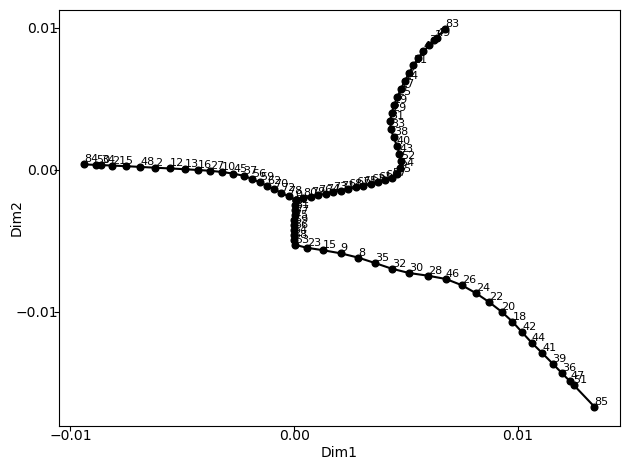

In [32]:
st.plot_branches(adata,show_text=True, n_components=2)

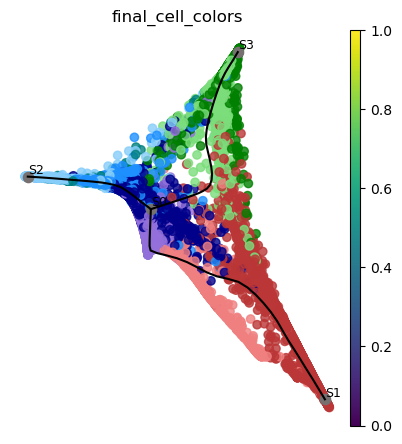

In [33]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True,color=['final_cell_colors'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


In [34]:
# ###Extend leaf branch to reach further cells 
# st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
# st.plot_dimension_reduction(adata,n_components=2,show_graph=True,show_text=True)
# st.plot_branches(adata,show_text=False)

In [35]:
adata.obs['gray'] = 'gray'  # Create a column called 'gray' with value 'gray'
adata.uns['gray'] = ['#D3D3D3']

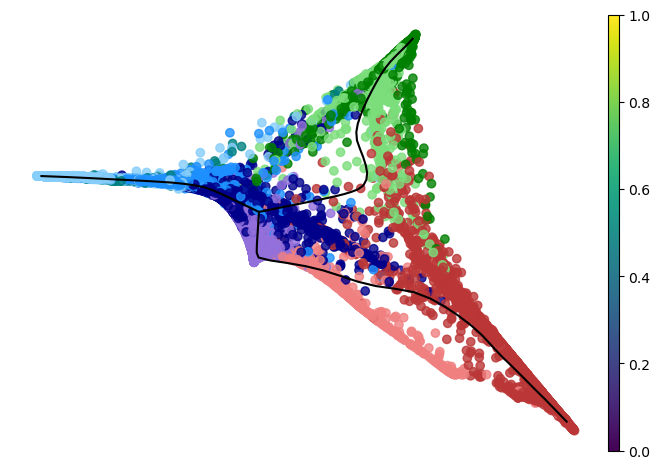

In [36]:
# Then plot
fig = st.plot_dimension_reduction(adata, color=['final_cell_colors'], n_components=2, show_graph=True, show_text=False)

# Get the current axes
ax = plt.gca()

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Remove spines (the box around the plot)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove title, legend, and labels
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/figures/colored_male_traj.pdf', 
#             bbox_inches='tight',  # Ensures the legend isn't cut off
#             dpi=300,             # High resolution
#             format='pdf')
plt.tight_layout()

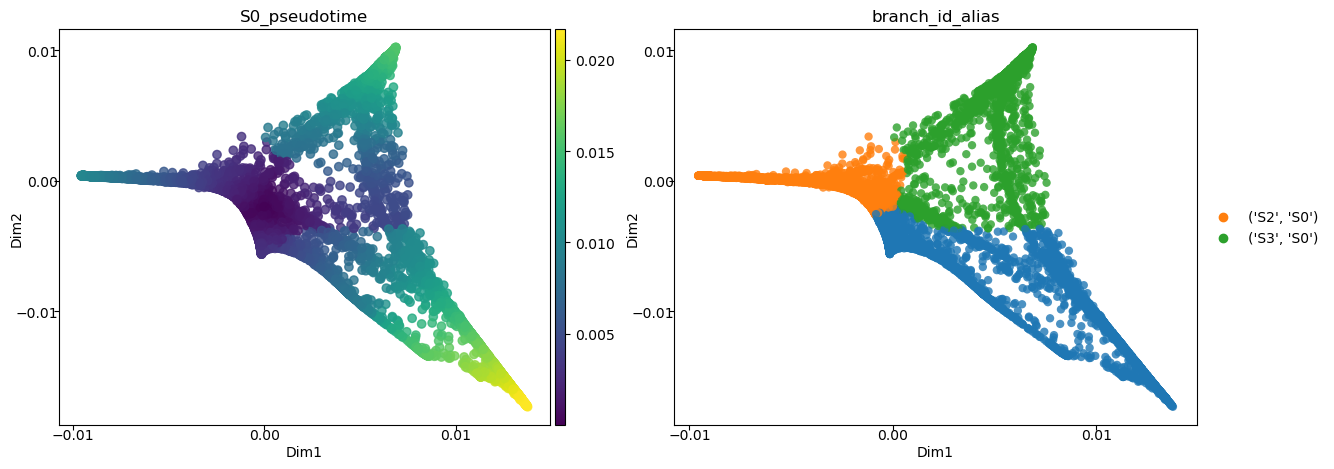

In [38]:
#Replace S3 with your own starting node if on a different dataset
st.plot_dimension_reduction(adata,color=['S0_pseudotime','branch_id_alias'])


#### Plot a subset of the adata to specify one state's differentiation

In [18]:
adata_subset = adata[adata.obs['branch_id_alias'] == ('S3', 'S0')]
adata_subset 

View of AnnData object with n_obs × n_vars = 7335 × 4142
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'score_G1S', 'score_G2M', 'score_myc_up', 'score_GC', 'score_PB', 'score_MBC_1', 'score_MBC_2', 'score_preGC', 'score_LZ_GC', 'score_DZ_GC', 'DNA_damage', 'LZ_vs_DZ_down', 'LZ_vs_DZ_up', 'Ag_presentation', 'BCR_signaling', 'leiden_filtered_cells', 'cell_type_annotation', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total

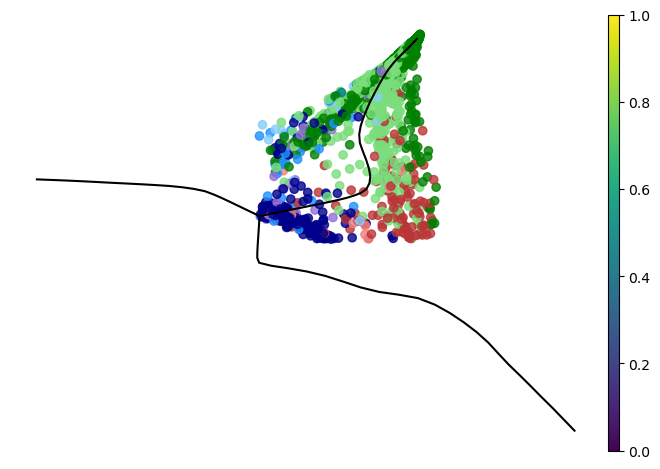

In [40]:
# Then plot
fig = st.plot_dimension_reduction(adata_subset, color=['final_cell_colors'], n_components=2, show_graph=True, show_text=False)

# Get the current axes
ax = plt.gca()

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Remove spines (the box around the plot)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove title, legend, and labels
ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
# plt.savefig('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/figures/gc_male_traj.pdf', 
#             bbox_inches='tight',  # Ensures the legend isn't cut off
#             dpi=300,             # High resolution
#             format='pdf')
plt.tight_layout()

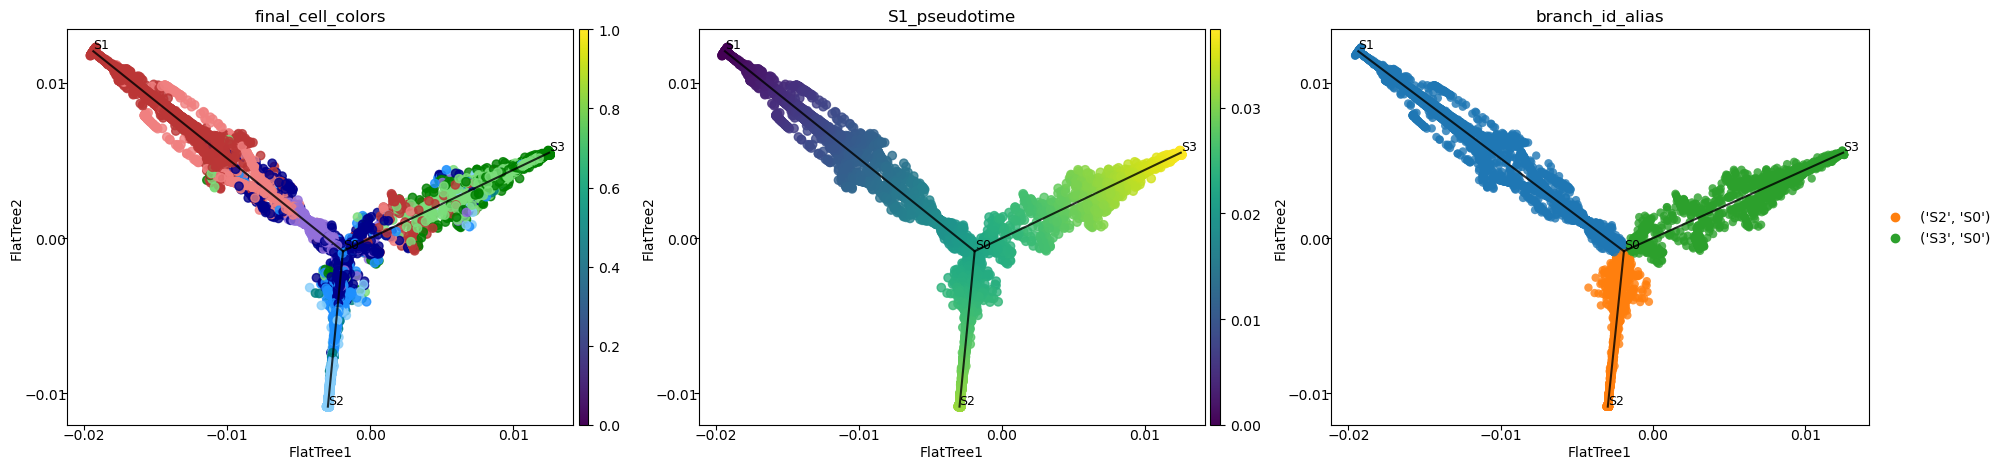

In [41]:
st.plot_flat_tree(adata,color=['final_cell_colors','S1_pseudotime','branch_id_alias'],
                  dist_scale=0.5,show_graph=True,show_text=True)


### Verifying genes of interest's expression per branch on the trajectory

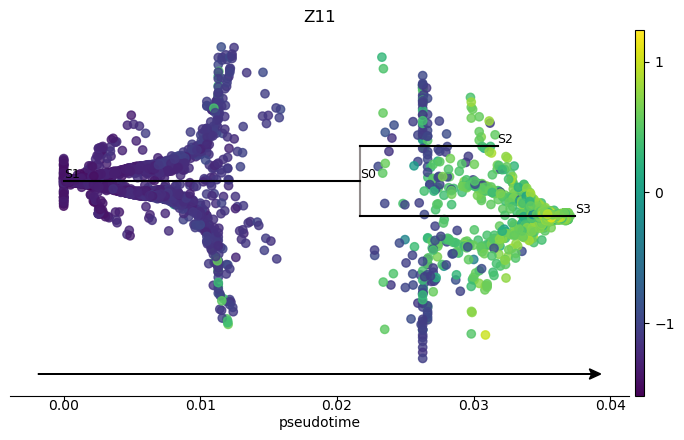

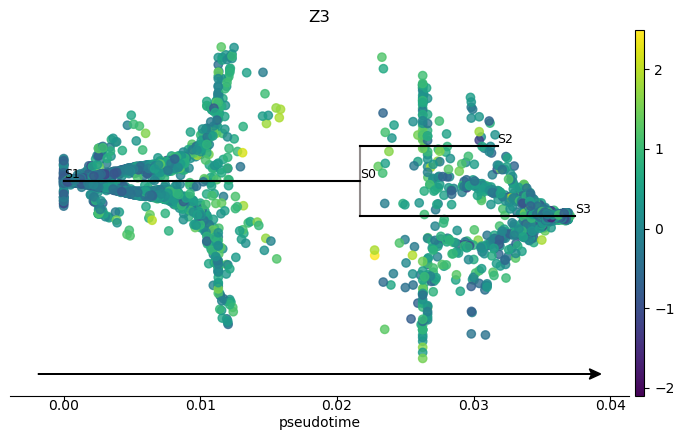

In [42]:
# Convert categorical columns to ordered categorical
for col in ['Z11', 'Z3']:
    if pd.api.types.is_categorical_dtype(adata.obs[col]):
        adata.obs[col] = adata.obs[col].astype('category').cat.as_ordered()

# Now plot
st.plot_stream_sc(adata, root='S1', color=['Z11', 'Z3'], show_graph=True, show_text=True)

In [43]:
adata.obs.head()

,sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,topic_0,topic_1,topic_2,topic_3,...,D2_per_BATF,D2_per_IRF4,D2_per_SPIB,D2_per_PRDM1,D2_per_IRF8,D4_per_BATF,D4_per_IRF4,D4_per_SPIB,D4_per_PRDM1,D4_per_IRF8
AAACAGCCAAGCCACT-3,day5_6,3580,3580,3657.756836,54.042961,1.372567,0.018575,0.013160,0.008065,0.036125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAAGGTGCA-1,day0_2,2415,2415,3112.943604,52.210323,1.541318,0.038631,0.025551,0.318661,0.011544,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAAGTTATC-1,day0_2,1435,1435,2431.045410,51.333004,1.906349,0.015908,0.023365,0.006621,0.007612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAATAGCCC-1,day0_2,1349,1349,2333.001465,47.939995,1.839260,0.011711,0.010980,0.044246,0.010271,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAACAGCCAGTTAGCC-1,day0_2,2017,2017,2874.929443,49.748478,1.569514,0.016863,0.013082,0.135453,0.012727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
# get max pseudotime for each branch
S1_max_pseudotime = adata.obs['S1_pseudotime'].max()
S2_max_pseudotime = adata.obs['S2_pseudotime'].max()
S3_max_pseudotime = adata.obs['S3_pseudotime'].max()
S0_max_pseudotime = adata.obs['S0_pseudotime'].max()
print(S1_max_pseudotime)
print(S2_max_pseudotime)
print(S3_max_pseudotime)
print(S0_max_pseudotime)


0.037409907438338025
0.03173738459651819
0.037409907438338025
0.021676226324986173


In [45]:
# # save the S2_pseudotime with barcodes (taken from obs.index) to a csv
# pseudotime_df = pd.DataFrame({'Barcode': adata.obs.index, 'S1_pseudotime': adata.obs['S1_pseudotime']})
# pseudotime_df.to_csv(os.path.join(stream_outs_path,'S1_pseudotime.csv'), index=False)


In [47]:
# write stream adata to pkl
st.write(adata,file_name=os.path.join(out_dir,'mlle_traj_male_donor.pkl'))

## Dictys inputs

In [27]:
import numpy as np
import pandas as pd
# Extract node names from pseudotime columns
dimnodes=np.array(sorted([x[:-len('_pseudotime')] for x in adata.obs.columns if x.endswith('_pseudotime')]))
dist=np.array([adata.obs.loc[adata.obs.index,x+'_pseudotime'].values for x in dimnodes]).T
node_dict=dict(zip(dimnodes,range(len(dimnodes))))
branch = np.array([
    sorted([node_dict.get(y.strip('() \''), None) for y in x])
    for x in adata.obs['branch_id_alias']
])

# save the branch, edge, and dist files

# The branch each cell is on (cell:(node_start,node_end))
branch=pd.DataFrame(branch,index=adata.obs.index)
#display(branch)
branch.to_csv(os.path.join(stream_outs_path,'branch.tsv.gz'),header=False,index=False,sep='\t')

# Identify and save unique edges between nodes
edge=np.unique(branch.values,axis=0)
display(edge)
edge=pd.DataFrame(edge)
edge.to_csv(os.path.join(stream_outs_path,'edge.tsv.gz'),header=False,index=False,sep='\t')

# The distance of each cell to each node (cell:node, value is pseudotime distance)
dist=pd.DataFrame(dist,index=adata.obs.index,columns=dimnodes)
dist.to_csv(os.path.join(stream_outs_path,'dist.tsv.gz'),header=True,index=True,sep='\t')

array([[0, 1],
       [0, 2],
       [0, 3]])

#### Make subsets of the sub cell types

In [30]:
adata.obs.sub_cell_type.to_csv(f'{dictys_data_path}/clusters.csv',header=['Cluster'],index=True,index_label='Barcode')


#### Make coord_rna.tsv.gz file of the cells and their lower dim coords, for dictys input

In [31]:
import anndata as ad
import pandas as pd

# Convert the obs.index (cell barcodes) to a DataFrame
obs_index_df = pd.DataFrame(adata.obs.index)
# Create a new AnnData object with only the cell barcodes and X_dr from obsm
adata_reduced = ad.AnnData(
    obs=obs_index_df,  # Use the cell barcodes as the obs DataFrame
    obsm={"X_dr": adata.obsm['X_dr']}  # Keep only 'X_dr' from obsm
)
# Confirm that the new AnnData object has the correct structure
adata_reduced

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 28494 × 0
    obs: 0
    obsm: 'X_dr'

In [32]:
import os
import pandas as pd

# Extract the relevant columns from the AnnData object
# The cell barcodes (obs.index) and 'X_dr' from obsm
cell_barcodes = adata.obs.index
xy_coords = adata_reduced.obsm['X_dr']

# Create a DataFrame with cell barcodes as the first column and 'X_dr' as the next columns
coord_df_b_cell = pd.DataFrame(data=xy_coords, columns=['x', 'y'])
coord_df_b_cell.insert(0, None, cell_barcodes)

#display the df
print(coord_df_b_cell.head())

                  NaN         x         y
0  AAACAGCCAAGCCACT-3  0.001589 -0.001502
1  AAACAGCCAAGGTGCA-1 -0.000893 -0.000170
2  AAACAGCCAAGTTATC-1 -0.001197 -0.000344
3  AAACAGCCAATAGCCC-1 -0.001334 -0.000409
4  AAACAGCCAGTTAGCC-1 -0.001249 -0.000377


In [33]:
# Save the DataFrame to a TSV file
output_path = os.path.join(dictys_data_path,'coord_rna.tsv.gz')
coord_df_b_cell.to_csv(output_path, sep='\t', compression='gzip', index=False, header=['', 'x', 'y'])